# Setting up the Data

## Setting up Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [ ]:
import urllib
file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "GbnXJ5bU3m9JPau", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('visapy_data.npy', 'wb') as out_file:
    data = response.read()
    out_file.write(data)

# raw data location
data_path = 'visapy_data.npy'

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

## Loading the data 

In [98]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 12
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [99]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


In [100]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

## Setting up the data

In [101]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(48009, 51)


## Defining the Model

In [7]:
class lstm_autoencoder(nn.Module):
    def __init__(self, input_size, seq_len, embedding_size):
        super(lstm_autoencoder, self).__init__()
        if input_size%seq_len != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.PReLU()
        
        first_lin_size = 28*(input_size//seq_len)
        
        self.lstm1 = nn.LSTM(input_size=seq_len, hidden_size=15, num_layers=2)
        self.lstm2 = nn.LSTM(input_size=15, hidden_size=28, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, 80)
        self.lin2 = nn.Linear(80, embedding_size)
        
        self.lin3 = nn.Linear(embedding_size, 16)
        self.lin4 = nn.Linear(16, 25)
        self.lin5 = nn.Linear(25, input_size)
    
    def forward(self, x, hidden=None):
        x = self.serialise_input(x, 3)
        out, _ = self.lstm1(x, hidden)
        out, _ = self.lstm2(out, hidden)
        out = self.flatten_input(out)
        out = self.lin1(out)
        out = self.activation_layer(out)
        enc = self.lin2(out)

        out = self.lin3(enc)
        out = self.activation_layer(out)
        out = self.lin4(out)
        out = self.activation_layer(out)
        dec = self.lin5(out)
        return enc, dec
    
    def serialise_input(self, data, seq_len):
        data = data.view(-1, 1, seq_len)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [8]:
def init_lstm_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)
    elif type(layer) == nn.LSTM:
        for name, param in layer.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal(param)

## Loading Models

In [9]:
lstm_ae_1 = torch.load('models/visapy/lstm_12.pt')
lstm_ae_2 = torch.load('models/visapy/lstm_10.pt')
lstm_ae_3 = torch.load('models/visapy/lstm_8.pt')
lstm_ae_4 = torch.load('models/visapy/lstm_6.pt')
lstm_ae_5 = torch.load('models/visapy/lstm_4.pt')
lstm_ae_6 = torch.load('models/visapy/lstm_2.pt')

## Testing 12-dim embedding

In [11]:
enc_12 = np.zeros([total_sigs, 12])
out_12 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_1.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_12[i, :] = enc[:]
    out_12[i, :] = o[:]

## Testing 10-dim embedding

In [16]:
enc_10 = np.zeros([total_sigs, 10])
out_10 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_2.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_10[i, :] = enc[:]
    out_10[i, :] = o[:]

## Testing 8-dim embedding

In [110]:
enc_8 = np.zeros([total_sigs, 8])
out_8 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_3.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_8[i, :] = enc[:]
    out_8[i, :] = o[:]

## Testing 6-dim embedding

In [19]:
enc_6 = np.zeros([total_sigs, 6])
out_6 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_4.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_6[i, :] = enc[:]
    out_6[i, :] = o[:]

## Testing 4-dim embedding

In [20]:
enc_4 = np.zeros([total_sigs, 4])
out_4 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_5.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_4[i, :] = enc[:]
    out_4[i, :] = o[:]

## Testing 2-dim embedding

In [102]:
enc_2 = np.zeros([total_sigs, 2])
out_2 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = lstm_ae_6.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_2[i, :] = enc[:]
    out_2[i, :] = o[:]

In [14]:
def find_mse(original, recons, params='all'):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        mse.append(np.mean(se))
    mse = np.array(mse)
  
    if params == 'median':
        return np.median(mse), np.std(mse)
    elif params == 'limits':
        return np.amax(mse), np.amin(mse)
    else:
        return np.median(mse), np.std(mse), np.amax(mse), np.amin(mse)

In [15]:
print(find_mse(electrode_data, out_12))

(27.716335126239095, 10.11353476012999, 109.40014214395727, 7.680354240966917)


In [17]:
print(find_mse(electrode_data, out_10))

(31.184644659728548, 11.79252935068707, 135.79132771051587, 8.969275516100083)


In [111]:
print(find_mse(electrode_data, out_8))

(36.45102918029764, 21.579901003177408, 1162.636083880353, 8.589648927830618)


In [23]:
print(find_mse(electrode_data, out_6))

(45.057123986258446, 23.320299112785687, 435.53319564609967, 11.985527335662487)


In [24]:
print(find_mse(electrode_data, out_4))

(62.65288943083746, 42.1906412006068, 762.6946296462925, 15.139654531672793)


In [103]:
print(find_mse(electrode_data, out_2))

(119.53669799284589, 135.22949294320136, 4585.164365284899, 14.837907617782232)


In [146]:
from herdingspikes.hs2 import HSClustering
C = HSClustering(H)

def gen_features(enc_data, pca=False):
    C.ShapePCA(pca_ncomponents=2, pca_whiten=True)
    if pca is False:
        print('Updating features from encoded data')
        C.features = enc_data
#print(C.features.shape)

In [147]:
def get_cluster(alpha):
    C.CombinedClustering(alpha=alpha, bandwidth=5., bin_seeding=False, n_jobs=-1)

    plt.figure(figsize=(14, 6))
    ax = plt.subplot(111)
    C.PlotAll(invert=True, s=1, ax=ax, max_show=100000, show_labels=False)
    plt.title("MeanShift, no bin seeding");

In [148]:
gen_features(enc_2)

Fitting PCA using 48009 spikes...
...projecting...
...done
Updating features from encoded data


Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   25.4s remaining:  1.3min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   28.5s remaining:    5.7s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   28.8s finished


Number of estimated units: 257


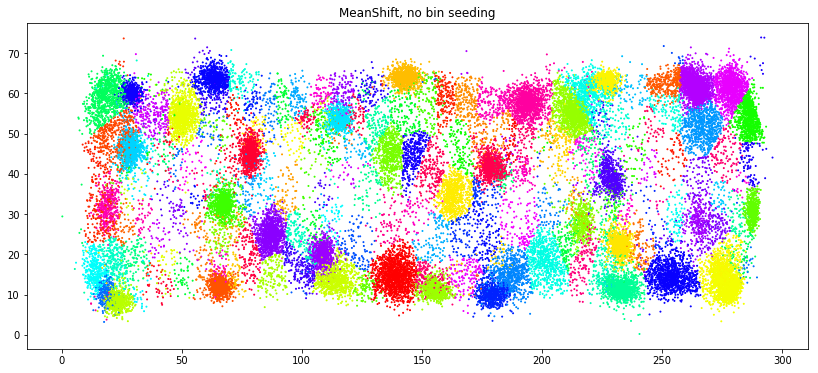

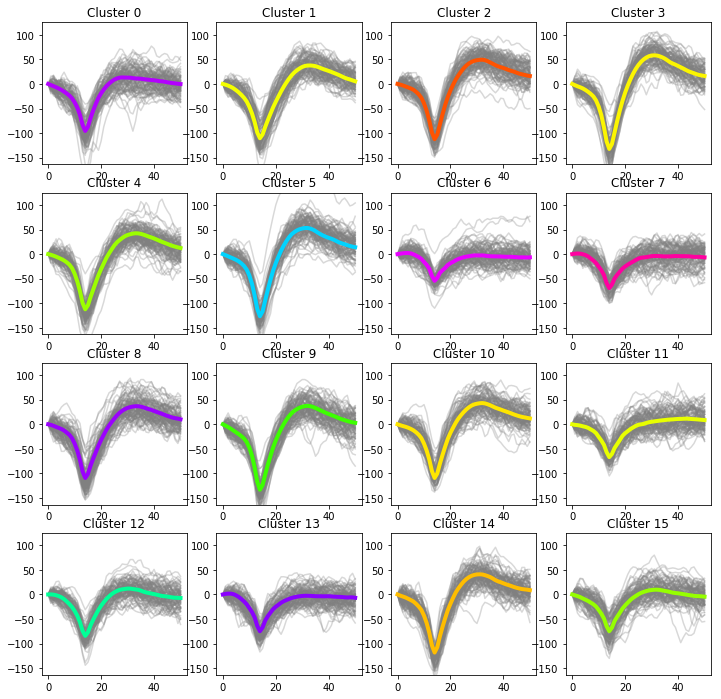

In [149]:
get_cluster(0.25)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   30.3s remaining:  1.5min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   35.7s remaining:    7.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   36.2s finished


Number of estimated units: 1104


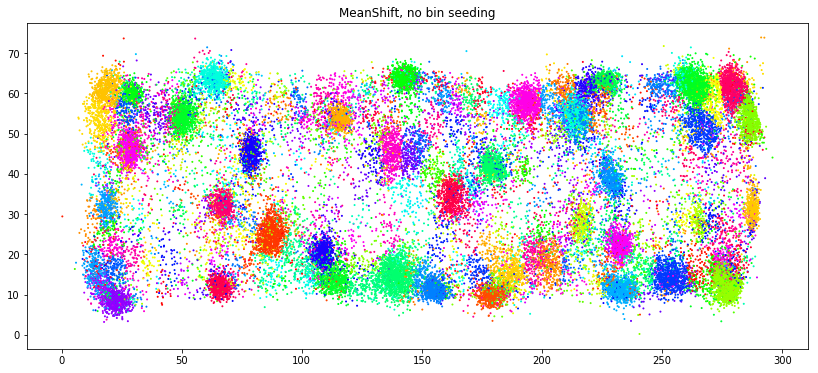

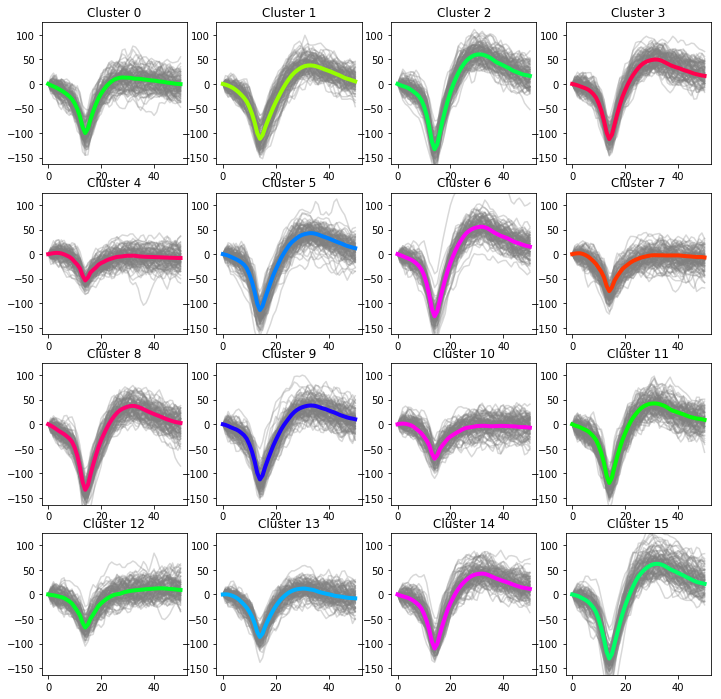

In [150]:
get_cluster(0.5)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   26.4s remaining:  1.3min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   27.6s remaining:    5.5s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   28.4s finished


Number of estimated units: 110


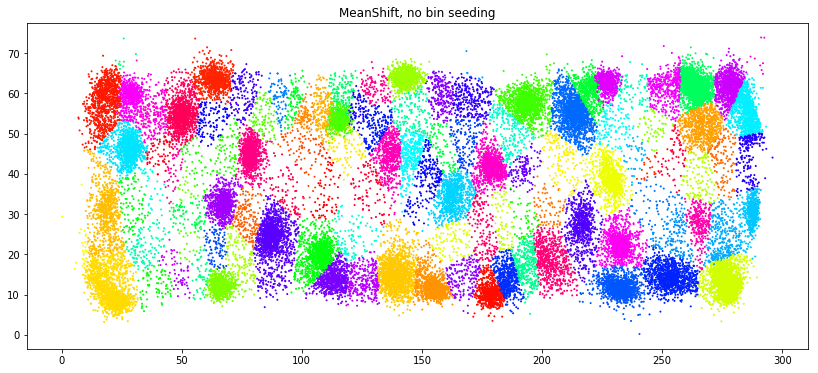

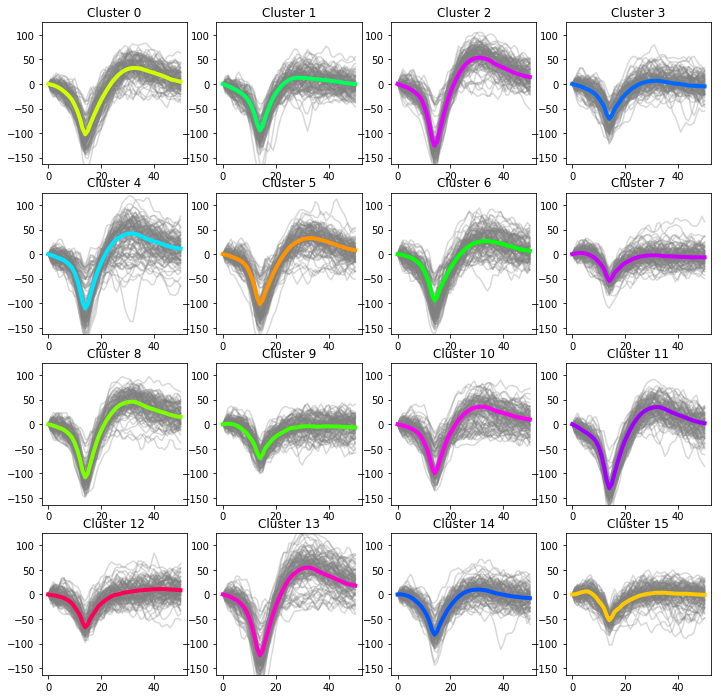

In [151]:
get_cluster(1)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   10.8s remaining:   32.4s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   11.3s remaining:    2.3s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   11.4s finished


Number of estimated units: 12237


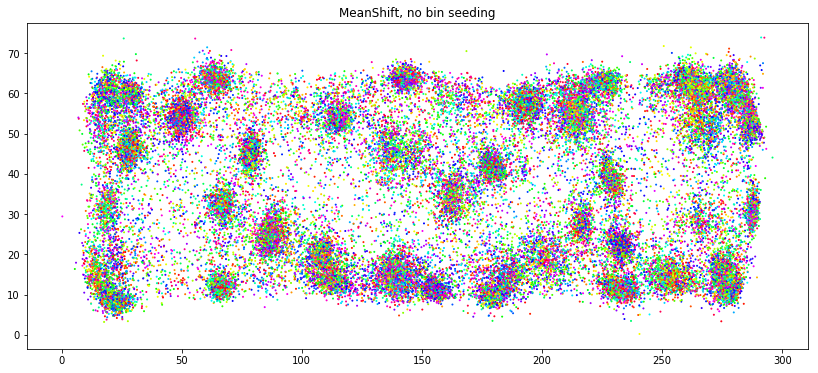

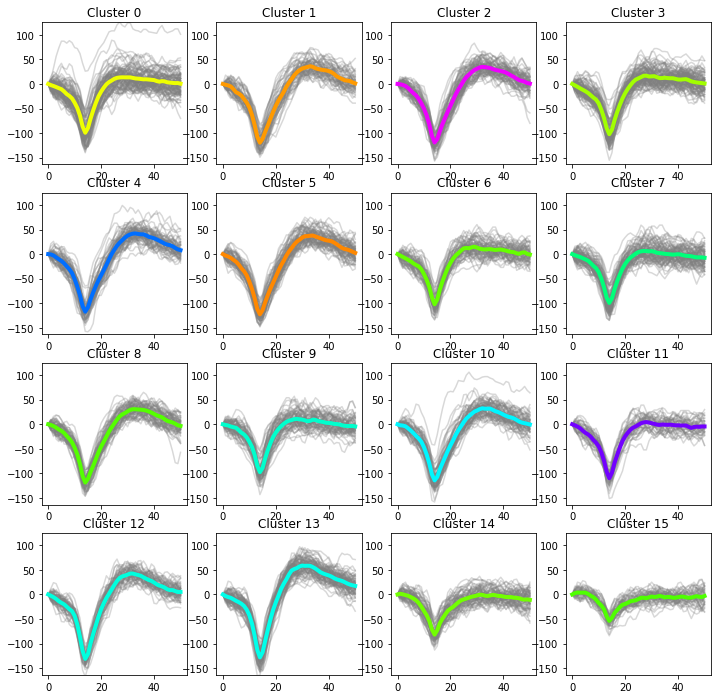

In [152]:
get_cluster(2)

units = range(16)
C.PlotShapes(units)